In [ ]:
!free -h


               total        used        free      shared  buff/cache   available
Mem:            12Gi       8.3Gi       2.7Gi       2.0Mi       1.7Gi       4.1Gi
Swap:             0B          0B          0B


In [ ]:
import psutil

# Get the memory in GB
memory = psutil.virtual_memory()
print(f"Total RAM: {memory.total / (1024**3):.2f} GB")
print(f"Used RAM: {memory.used / (1024**3):.2f} GB")
print(f"Free RAM: {memory.free / (1024**3):.2f} GB")


Total RAM: 12.67 GB
Used RAM: 3.28 GB
Free RAM: 0.32 GB


In [ ]:
from torchvision.models import ConvNeXt_Tiny_Weights

# Show available weights and metadata
print(ConvNeXt_Tiny_Weights.IMAGENET1K_V1)  # Shows default weight enum
print(ConvNeXt_Tiny_Weights.IMAGENET1K_V1.url)  # Download URL


ConvNeXt_Tiny_Weights.IMAGENET1K_V1
https://download.pytorch.org/models/convnext_tiny-983f1562.pth


#ConvNeXT

In [ ]:
import gc
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch import nn
import torch.cuda.amp as amp


# Load ConvNeXt Model
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)  # 3 classes
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset (update paths if needed)
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_convnext_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=2, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()
    for epoch in range(num_epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backpropagation
            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validate after each epoch
        validate_model(model, val_loader, criterion, device)

        torch.cuda.empty_cache()

# Validation loop
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Validation Loss: {running_loss/len(val_loader):.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Test loop
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Run training, validation, and testing
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)


<ipython-input-7-b0317004f865>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-7-b0317004f865>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/10], Loss: 0.4532


<ipython-input-7-b0317004f865>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Validation Loss: 0.3429
Validation Accuracy: 88.00%
Epoch [2/10], Loss: 0.1418
Validation Loss: 0.3152
Validation Accuracy: 85.60%
Epoch [3/10], Loss: 0.0721
Validation Loss: 0.2070
Validation Accuracy: 92.00%
Epoch [4/10], Loss: 0.0381
Validation Loss: 0.3488
Validation Accuracy: 92.80%
Epoch [5/10], Loss: 0.0076
Validation Loss: 0.2207
Validation Accuracy: 94.40%
Epoch [6/10], Loss: 0.0158
Validation Loss: 0.1858
Validation Accuracy: 95.20%
Epoch [7/10], Loss: 0.0024
Validation Loss: 0.2102
Validation Accuracy: 93.60%
Epoch [8/10], Loss: 0.0004
Validation Loss: 0.2115
Validation Accuracy: 96.00%
Epoch [9/10], Loss: 0.0002
Validation Loss: 0.2186
Validation Accuracy: 96.00%
Epoch [10/10], Loss: 0.0002
Validation Loss: 0.2242
Validation Accuracy: 96.00%


<ipython-input-7-b0317004f865>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test Loss: 0.1272
Test Accuracy: 98.41%


In [ ]:
import gc
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch import nn
import torch.cuda.amp as amp
import time

# Load ConvNeXt Model
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)  # 3 classes
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_convnext_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with time complexity and timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    """
    Time Complexity Analysis:
    - N: Number of dataset samples
    - B: Batch size (4)
    - E: Number of epochs (10)
    - A: Gradient accumulation steps (4)
    - C: Complexity of forward+backward pass through ConvNeXt-Tiny per batch
    - C_f: Complexity of forward pass only per batch
    - Training loop: O(E * ceil(0.8N/B) * C)
    - Validation loop: O(E * ceil(0.1N/B) * C_f)
    - Total (excluding final test): O(E * ceil(N/B) * C)
    """
    print("Time Complexity Analysis:")
    print("- Training: O(E * ceil(0.8N/B) * C), where N is dataset size, B=4 (batch size), E=10 (epochs), C is model forward+backward complexity")
    print("- Validation: O(E * ceil(0.1N/B) * C_f), where C_f is model forward complexity")
    print("- Overall (excluding final test): O(E * ceil(N/B) * C)")

    model.train()
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        running_loss = 0.0
        optimizer.zero_grad()
        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backpropagation
            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Epoch Time: {epoch_time:.2f}s")

        # Validate after each epoch
        validate_model(model, val_loader, criterion, device)

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Validation loop
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Validation Loss: {running_loss/len(val_loader):.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Test loop
def test_model(model, test_loader, criterion, device):
    """
    Time Complexity: O(ceil(0.1N/B) * C_f), where N is dataset size, B=4, C_f is forward pass complexity
    """
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Run training, validation, and testing
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

Time Complexity Analysis:
- Training: O(E * ceil(0.8N/B) * C), where N is dataset size, B=4 (batch size), E=10 (epochs), C is model forward+backward complexity
- Validation: O(E * ceil(0.1N/B) * C_f), where C_f is model forward complexity
- Overall (excluding final test): O(E * ceil(N/B) * C)


/tmp/ipython-input-5-4036330845.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipython-input-5-4036330845.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/10], Loss: 0.4514, Epoch Time: 26.16s


/tmp/ipython-input-5-4036330845.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Validation Loss: 0.2699
Validation Accuracy: 89.60%
Epoch [2/10], Loss: 0.1213, Epoch Time: 25.15s
Validation Loss: 0.4647
Validation Accuracy: 79.20%
Epoch [3/10], Loss: 0.0532, Epoch Time: 24.72s
Validation Loss: 0.3246
Validation Accuracy: 88.80%
Epoch [4/10], Loss: 0.0320, Epoch Time: 25.56s
Validation Loss: 0.3443
Validation Accuracy: 87.20%
Epoch [5/10], Loss: 0.0138, Epoch Time: 24.83s
Validation Loss: 0.4558
Validation Accuracy: 91.20%
Epoch [6/10], Loss: 0.0207, Epoch Time: 25.10s
Validation Loss: 0.4703
Validation Accuracy: 87.20%
Epoch [7/10], Loss: 0.0328, Epoch Time: 24.79s
Validation Loss: 0.1759
Validation Accuracy: 92.80%
Epoch [8/10], Loss: 0.0070, Epoch Time: 25.61s
Validation Loss: 0.2992
Validation Accuracy: 91.20%
Epoch [9/10], Loss: 0.0005, Epoch Time: 24.58s
Validation Loss: 0.2851
Validation Accuracy: 93.60%
Epoch [10/10], Loss: 0.0002, Epoch Time: 25.45s
Validation Loss: 0.3161
Validation Accuracy: 92.80%
Total Training Time (including validation): 274.44s


/tmp/ipython-input-5-4036330845.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test Loss: 0.2264
Test Accuracy: 93.65%


#Inception-V3

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch import nn
import torch.amp as amp  # updated import for mixed precision

# Load InceptionV3 Model properly with aux_logits=True
def get_inception_resnet_model():
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 3)  # Aux classifier output for 3 classes
    model.fc = nn.Linear(model.fc.in_features, 3)  # Main classifier output for 3 classes
    return model

# Preprocessing and Data Augmentation for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset (replace with your actual dataset path)
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_inception_resnet_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation and mixed precision
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        torch.cuda.empty_cache()

# Testing loop with accuracy calculation and mixed precision
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)  # no [0] indexing here
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Validation loop with accuracy calculation and mixed precision
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)
validate_model(model, val_loader, criterion, device)
test_model(model, test_loader, criterion, device)


Epoch [1/10], Loss: 0.9704
Epoch [2/10], Loss: 0.3283
Epoch [3/10], Loss: 0.1265
Epoch [4/10], Loss: 0.0610
Epoch [5/10], Loss: 0.0336
Epoch [6/10], Loss: 0.0374
Epoch [7/10], Loss: 0.0214
Epoch [8/10], Loss: 0.0123
Epoch [9/10], Loss: 0.0133
Epoch [10/10], Loss: 0.0439
Validation Loss: 0.4575
Validation Accuracy: 90.40%
Test Loss: 0.1477
Test Accuracy: 97.62%


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch import nn
import torch.amp as amp
import time

# Load InceptionV3 Model properly with aux_logits=True
def get_inception_resnet_model():
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 3)  # Aux classifier output for 3 classes
    model.fc = nn.Linear(model.fc.in_features, 3)  # Main classifier output for 3 classes
    return model

# Preprocessing and Data Augmentation for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_inception_resnet_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation, mixed precision, and timing
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)  # InceptionOutputs tuple
                loss1 = criterion(outputs.logits, labels)  # Main output
                loss2 = criterion(outputs.aux_logits, labels)  # Auxiliary output
                loss = loss1 + 0.4 * loss2

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time: {total_time:.2f}s")

# Testing loop with accuracy calculation and mixed precision
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)  # Single output (logits) in eval mode
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Validation loop with accuracy calculation and mixed precision
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)
validate_model(model, val_loader, criterion, device)
test_model(model, test_loader, criterion, device)

Epoch [1/10], Loss: 0.9788, Epoch Time: 23.56s
Epoch [2/10], Loss: 0.2478, Epoch Time: 22.57s
Epoch [3/10], Loss: 0.0870, Epoch Time: 22.22s
Epoch [4/10], Loss: 0.0477, Epoch Time: 22.26s
Epoch [5/10], Loss: 0.0455, Epoch Time: 23.47s
Epoch [6/10], Loss: 0.0374, Epoch Time: 22.64s
Epoch [7/10], Loss: 0.0208, Epoch Time: 21.99s
Epoch [8/10], Loss: 0.0209, Epoch Time: 22.57s
Epoch [9/10], Loss: 0.0121, Epoch Time: 22.36s
Epoch [10/10], Loss: 0.0180, Epoch Time: 22.39s
Total Training Time: 226.36s
Validation Loss: 0.1258
Validation Accuracy: 96.00%
Test Loss: 0.1971
Test Accuracy: 93.65%


#EdgeNext

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.amp as amp
import timm  # PyTorch Image Models for EdgeNext

# Set random seed for reproducibility
torch.manual_seed(42)

# Load EdgeNext Model
def get_edgenext_model(num_classes=3):
    # Load pre-trained EdgeNext model from timm (e.g., 'edgenext_small')
    # Check available models with timm.list_models('*edgenext*')
    model = timm.create_model('edgenext_small', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation for EdgeNext
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EdgeNext typically uses 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/new_train_img', transform=transform)

# Calculate split sizes (80% train, 10% validation, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # ~10% for test

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Option: Use separate test dataset instead of splitting
# test_dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/real_test_img', transform=transform)
# If using this, split new_train_img into 80% train, 20% validation:
# train_size = int(0.8 * total_size)
# val_size = total_size - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_edgenext_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation, mixed precision, and validation
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)  # EdgeNext has no auxiliary logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

# Testing loop with accuracy calculation and mixed precision
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

Epoch [1/10], Train Loss: 0.8844
Epoch [1/10], Val Loss: 0.6102, Val Accuracy: 79.20%
Epoch [2/10], Train Loss: 0.4552
Epoch [2/10], Val Loss: 0.3660, Val Accuracy: 89.60%
Epoch [3/10], Train Loss: 0.2755
Epoch [3/10], Val Loss: 0.2321, Val Accuracy: 93.60%
Epoch [4/10], Train Loss: 0.1733
Epoch [4/10], Val Loss: 0.2077, Val Accuracy: 93.60%
Epoch [5/10], Train Loss: 0.0980
Epoch [5/10], Val Loss: 0.1879, Val Accuracy: 93.60%
Epoch [6/10], Train Loss: 0.0450
Epoch [6/10], Val Loss: 0.2036, Val Accuracy: 95.20%
Epoch [7/10], Train Loss: 0.0198
Epoch [7/10], Val Loss: 0.2041, Val Accuracy: 95.20%
Epoch [8/10], Train Loss: 0.0122
Epoch [8/10], Val Loss: 0.2325, Val Accuracy: 95.20%
Epoch [9/10], Train Loss: 0.0083
Epoch [9/10], Val Loss: 0.2349, Val Accuracy: 94.40%
Epoch [10/10], Train Loss: 0.0065
Epoch [10/10], Val Loss: 0.2256, Val Accuracy: 95.20%
Test Loss: 0.1761
Test Accuracy: 96.03%


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.amp as amp
import timm
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# Load EdgeNext Model
def get_edgenext_model(num_classes=3):
    model = timm.create_model('edgenext_small', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation for EdgeNext
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EdgeNext typically uses 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/new_train_img', transform=transform)

# Calculate split sizes (80% train, 10% validation, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # ~10% for test

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_edgenext_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation, mixed precision, validation, and timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        running_loss = 0.0
        optimizer.zero_grad()

        # Training phase
        model.train()
        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)  # EdgeNext has no auxiliary logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Testing loop with accuracy calculation and mixed precision
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.9041
Epoch [1/10], Val Loss: 0.6416, Val Accuracy: 79.20%
Epoch [1/10], Epoch Time: 240.01s
Epoch [2/10], Train Loss: 0.4699
Epoch [2/10], Val Loss: 0.3552, Val Accuracy: 90.40%
Epoch [2/10], Epoch Time: 12.25s
Epoch [3/10], Train Loss: 0.2704
Epoch [3/10], Val Loss: 0.2228, Val Accuracy: 95.20%
Epoch [3/10], Epoch Time: 13.07s
Epoch [4/10], Train Loss: 0.1619
Epoch [4/10], Val Loss: 0.1763, Val Accuracy: 95.20%
Epoch [4/10], Epoch Time: 12.14s
Epoch [5/10], Train Loss: 0.0906
Epoch [5/10], Val Loss: 0.1666, Val Accuracy: 95.20%
Epoch [5/10], Epoch Time: 12.33s
Epoch [6/10], Train Loss: 0.0475
Epoch [6/10], Val Loss: 0.2437, Val Accuracy: 95.20%
Epoch [6/10], Epoch Time: 12.57s
Epoch [7/10], Train Loss: 0.0225
Epoch [7/10], Val Loss: 0.1906, Val Accuracy: 94.40%
Epoch [7/10], Epoch Time: 16.95s
Epoch [8/10], Train Loss: 0.0175
Epoch [8/10], Val Loss: 0.1727, Val Accuracy: 94.40%
Epoch [8/10], Epoch Time: 12.32s
Epoch [9/10], Train Loss: 0.0109
Epoch [9/10], 

#Resnet

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.amp as amp
import timm  # PyTorch Image Models for ResNeSt

# Set random seed for reproducibility
torch.manual_seed(42)

# Load ResNeSt Model
def get_resnest_model(num_classes=3):
    # Load pre-trained ResNeSt model from timm (e.g., 'resnest50d')
    # Check available models with timm.list_models('*resnest*')
    model = timm.create_model('resnest50d', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation for ResNeSt
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNeSt typically uses 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Calculate split sizes (80% train, 10% validation, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_resnest_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation, mixed precision, and validation
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

# Testing loop
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.6435
Epoch [1/10], Val Loss: 0.3074, Val Accuracy: 87.20%
Epoch [2/10], Train Loss: 0.1836
Epoch [2/10], Val Loss: 0.1921, Val Accuracy: 90.40%
Epoch [3/10], Train Loss: 0.0699
Epoch [3/10], Val Loss: 0.1950, Val Accuracy: 92.00%
Epoch [4/10], Train Loss: 0.0423
Epoch [4/10], Val Loss: 0.3061, Val Accuracy: 93.60%
Epoch [5/10], Train Loss: 0.0460
Epoch [5/10], Val Loss: 0.2027, Val Accuracy: 95.20%
Epoch [6/10], Train Loss: 0.0215
Epoch [6/10], Val Loss: 0.1487, Val Accuracy: 93.60%
Epoch [7/10], Train Loss: 0.0252
Epoch [7/10], Val Loss: 0.2264, Val Accuracy: 93.60%
Epoch [8/10], Train Loss: 0.0138
Epoch [8/10], Val Loss: 0.2642, Val Accuracy: 94.40%
Epoch [9/10], Train Loss: 0.0129
Epoch [9/10], Val Loss: 0.3653, Val Accuracy: 94.40%
Epoch [10/10], Train Loss: 0.0152
Epoch [10/10], Val Loss: 0.2607, Val Accuracy: 93.60%
Test Loss: 0.1355
Test Accuracy: 96.83%


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.amp as amp
import timm
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# Load ResNeSt Model
def get_resnest_model(num_classes=3):
    model = timm.create_model('resnest50d', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation for ResNeSt
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNeSt typically uses 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Calculate split sizes (80% train, 10% validation, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_resnest_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with gradient accumulation, mixed precision, validation, and timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    model.train()
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Testing loop
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.6435
Epoch [1/10], Val Loss: 0.2855, Val Accuracy: 88.80%
Epoch [1/10], Epoch Time: 25.61s
Epoch [2/10], Train Loss: 0.1707
Epoch [2/10], Val Loss: 0.2003, Val Accuracy: 92.80%
Epoch [2/10], Epoch Time: 23.40s
Epoch [3/10], Train Loss: 0.0720
Epoch [3/10], Val Loss: 0.2196, Val Accuracy: 92.80%
Epoch [3/10], Epoch Time: 23.66s
Epoch [4/10], Train Loss: 0.0397
Epoch [4/10], Val Loss: 0.2167, Val Accuracy: 93.60%
Epoch [4/10], Epoch Time: 25.07s
Epoch [5/10], Train Loss: 0.0326
Epoch [5/10], Val Loss: 0.1709, Val Accuracy: 95.20%
Epoch [5/10], Epoch Time: 23.52s
Epoch [6/10], Train Loss: 0.0196
Epoch [6/10], Val Loss: 0.1692, Val Accuracy: 93.60%
Epoch [6/10], Epoch Time: 28.17s
Epoch [7/10], Train Loss: 0.0144
Epoch [7/10], Val Loss: 0.3342, Val Accuracy: 88.00%
Epoch [7/10], Epoch Time: 25.12s
Epoch [8/10], Train Loss: 0.0293
Epoch [8/10], Val Loss: 0.2756, Val Accuracy: 92.80%
Epoch [8/10], Epoch Time: 26.61s
Epoch [9/10], Train Loss: 0.0225
Epoch [9/10], V

#EfficientNet-v2

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.amp as amp
import timm
import time

# Set random seed
torch.manual_seed(42)

# Load pretrained EfficientNetV2 model from timm
def get_efficientv2_model(num_classes=3):
    model = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required input size for EfficientNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_efficientv2_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function with timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 3.3036
Epoch [1/10], Val Loss: 0.8860, Val Accuracy: 84.80%
Epoch [1/10], Epoch Time: 25.27s
Epoch [2/10], Train Loss: 0.3887
Epoch [2/10], Val Loss: 0.8161, Val Accuracy: 90.40%
Epoch [2/10], Epoch Time: 23.38s
Epoch [3/10], Train Loss: 0.1168
Epoch [3/10], Val Loss: 0.6849, Val Accuracy: 84.80%
Epoch [3/10], Epoch Time: 23.29s
Epoch [4/10], Train Loss: 0.0421
Epoch [4/10], Val Loss: 0.6793, Val Accuracy: 91.20%
Epoch [4/10], Epoch Time: 23.67s
Epoch [5/10], Train Loss: 0.0232
Epoch [5/10], Val Loss: 0.8589, Val Accuracy: 92.00%
Epoch [5/10], Epoch Time: 23.83s
Epoch [6/10], Train Loss: 0.0286
Epoch [6/10], Val Loss: 0.6709, Val Accuracy: 89.60%
Epoch [6/10], Epoch Time: 23.57s
Epoch [7/10], Train Loss: 0.0253
Epoch [7/10], Val Loss: 0.6184, Val Accuracy: 90.40%
Epoch [7/10], Epoch Time: 22.65s
Epoch [8/10], Train Loss: 0.0205
Epoch [8/10], Val Loss: 0.7040, Val Accuracy: 91.20%
Epoch [8/10], Epoch Time: 23.50s
Epoch [9/10], Train Loss: 0.0225
Epoch [9/10], V

#ViT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.amp as amp
import timm  # For pretrained ViT models

# Set random seed
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Vision Transformer (ViT) model
def get_vit_model(num_classes=3):
    # Use pretrained ViT (e.g., vit_base_patch32_224)
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for 3-class classification
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss function, and optimizer
model = get_vit_model(num_classes=3).to(device)  # The model is moved to the GPU inside get_vit_model function
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects class indices
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                # Ensure labels are integer values (for classification tasks)
                labels = labels.long()

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)


Using device: cpu


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.7769
Epoch [1/10], Val Loss: 0.2824, Val Accuracy: 90.40%
Epoch [2/10], Train Loss: 0.2034
Epoch [2/10], Val Loss: 0.2090, Val Accuracy: 90.40%
Epoch [3/10], Train Loss: 0.0638
Epoch [3/10], Val Loss: 0.2905, Val Accuracy: 92.00%
Epoch [4/10], Train Loss: 0.0462
Epoch [4/10], Val Loss: 0.2818, Val Accuracy: 94.40%
Epoch [5/10], Train Loss: 0.0722
Epoch [5/10], Val Loss: 0.2543, Val Accuracy: 91.20%
Epoch [6/10], Train Loss: 0.0182
Epoch [6/10], Val Loss: 0.2346, Val Accuracy: 93.60%
Epoch [7/10], Train Loss: 0.0024
Epoch [7/10], Val Loss: 0.2906, Val Accuracy: 93.60%
Epoch [8/10], Train Loss: 0.0006
Epoch [8/10], Val Loss: 0.3064, Val Accuracy: 93.60%
Epoch [9/10], Train Loss: 0.0003
Epoch [9/10], Val Loss: 0.3022, Val Accuracy: 93.60%
Epoch [10/10], Train Loss: 0.0002
Epoch [10/10], Val Loss: 0.3055, Val Accuracy: 93.60%
Test Loss: 0.1538
Test Accuracy: 96.03%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.amp as amp
import timm
import time

# Set random seed
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Vision Transformer (ViT) model
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for 3-class classification
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss function, and optimizer
model = get_vit_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function with timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.long()

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

Using device: cuda


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 1.0592
Epoch [1/10], Val Loss: 0.4730, Val Accuracy: 72.00%
Epoch [1/10], Epoch Time: 22.44s
Epoch [2/10], Train Loss: 0.2409
Epoch [2/10], Val Loss: 0.2263, Val Accuracy: 87.20%
Epoch [2/10], Epoch Time: 19.99s
Epoch [3/10], Train Loss: 0.0763
Epoch [3/10], Val Loss: 0.2248, Val Accuracy: 95.20%
Epoch [3/10], Epoch Time: 20.55s
Epoch [4/10], Train Loss: 0.0071
Epoch [4/10], Val Loss: 0.2490, Val Accuracy: 94.40%
Epoch [4/10], Epoch Time: 20.01s
Epoch [5/10], Train Loss: 0.0015
Epoch [5/10], Val Loss: 0.4086, Val Accuracy: 94.40%
Epoch [5/10], Epoch Time: 20.31s
Epoch [6/10], Train Loss: 0.0007
Epoch [6/10], Val Loss: 0.3152, Val Accuracy: 95.20%
Epoch [6/10], Epoch Time: 20.32s
Epoch [7/10], Train Loss: 0.0003
Epoch [7/10], Val Loss: 0.3442, Val Accuracy: 95.20%
Epoch [7/10], Epoch Time: 20.09s
Epoch [8/10], Train Loss: 0.0002
Epoch [8/10], Val Loss: 0.3760, Val Accuracy: 94.40%
Epoch [8/10], Epoch Time: 20.55s
Epoch [9/10], Train Loss: 0.0001
Epoch [9/10], V

#DeiT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.amp as amp
import timm  # For pretrained DeiT models

# Set random seed
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained DeiT model
def get_deit_model(num_classes=3):
    # Use pretrained DeiT model (e.g., deit_base_patch16_224)
    model = timm.create_model('deit_base_patch16_224', pretrained=True)

    # Explicitly move the model to GPU after creation (to make sure weights are on the correct device)
    model = model.to(device)

    # Modify the model head for classification
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for 3-class classification

    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for DeiT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss function, and optimizer
model = get_deit_model(num_classes=3)  # The model is moved to the GPU inside get_deit_model function
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects class indices
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                # Ensure labels are integer values (for classification tasks)
                labels = labels.long()

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)


Using device: cpu
Epoch [1/10], Train Loss: 0.5464
Epoch [1/10], Val Loss: 0.2738, Val Accuracy: 88.00%
Epoch [2/10], Train Loss: 0.2201
Epoch [2/10], Val Loss: 0.2292, Val Accuracy: 88.00%
Epoch [3/10], Train Loss: 0.1227
Epoch [3/10], Val Loss: 0.2554, Val Accuracy: 93.60%
Epoch [4/10], Train Loss: 0.0376
Epoch [4/10], Val Loss: 0.1810, Val Accuracy: 95.20%
Epoch [5/10], Train Loss: 0.0094
Epoch [5/10], Val Loss: 0.2525, Val Accuracy: 91.20%
Epoch [6/10], Train Loss: 0.0036
Epoch [6/10], Val Loss: 0.3713, Val Accuracy: 92.80%
Epoch [7/10], Train Loss: 0.0017
Epoch [7/10], Val Loss: 0.3390, Val Accuracy: 93.60%
Epoch [8/10], Train Loss: 0.0032
Epoch [8/10], Val Loss: 0.2934, Val Accuracy: 93.60%
Epoch [9/10], Train Loss: 0.0019
Epoch [9/10], Val Loss: 0.2471, Val Accuracy: 92.80%
Epoch [10/10], Train Loss: 0.0006
Epoch [10/10], Val Loss: 0.4137, Val Accuracy: 93.60%
Test Loss: 0.1217
Test Accuracy: 96.83%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.amp as amp
import timm
import time

# Set random seed
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained DeiT model
def get_deit_model(num_classes=3):
    # Use pretrained DeiT model (e.g., deit_base_patch16_224)
    model = timm.create_model('deit_base_patch16_224', pretrained=True)
    # Modify the head before moving to device
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for 3-class classification
    # Move the entire model to the device
    model = model.to(device)
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for DeiT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup model, loss function, and optimizer
model = get_deit_model(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function with timing
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()
    total_start_time = time.time()  # Start timing for total training

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.long()

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)

Using device: cuda
Epoch [1/10], Train Loss: 0.6316
Epoch [1/10], Val Loss: 0.2744, Val Accuracy: 88.80%
Epoch [1/10], Epoch Time: 26.01s
Epoch [2/10], Train Loss: 0.2240
Epoch [2/10], Val Loss: 0.3975, Val Accuracy: 78.40%
Epoch [2/10], Epoch Time: 24.54s
Epoch [3/10], Train Loss: 0.1190
Epoch [3/10], Val Loss: 0.2365, Val Accuracy: 87.20%
Epoch [3/10], Epoch Time: 23.74s
Epoch [4/10], Train Loss: 0.0333
Epoch [4/10], Val Loss: 0.2054, Val Accuracy: 92.80%
Epoch [4/10], Epoch Time: 24.39s
Epoch [5/10], Train Loss: 0.0054
Epoch [5/10], Val Loss: 0.1824, Val Accuracy: 93.60%
Epoch [5/10], Epoch Time: 25.21s
Epoch [6/10], Train Loss: 0.0010
Epoch [6/10], Val Loss: 0.1967, Val Accuracy: 94.40%
Epoch [6/10], Epoch Time: 24.67s
Epoch [7/10], Train Loss: 0.0005
Epoch [7/10], Val Loss: 0.2167, Val Accuracy: 95.20%
Epoch [7/10], Epoch Time: 24.68s
Epoch [8/10], Train Loss: 0.0004
Epoch [8/10], Val Loss: 0.2191, Val Accuracy: 95.20%
Epoch [8/10], Epoch Time: 24.75s
Epoch [9/10], Train Loss: 0.0

#Ensemble(Deit + Efficientv2) soft voting

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.amp as amp
import timm  # For pretrained models

# Load pretrained DeiT model
def get_deit_model(num_classes=3):
    model = timm.create_model('deit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for classification
    return model

# Load pretrained EfficientNetV2 model
def get_efficientv2_model(num_classes=3):
    model = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=num_classes)
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for both models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split dataset (80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
deit_model = get_deit_model(num_classes=3).to(device)
efficientnet_model = get_efficientv2_model(num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(deit_model.parameters()) + list(efficientnet_model.parameters()), lr=1e-4)

# Training function (for both models)
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    scaler = amp.GradScaler()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % 4 == 0:  # Gradient Accumulation
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Testing function (for both models)
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train both models
train_model(deit_model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
train_model(efficientnet_model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

# Test both models
test_model(deit_model, test_loader, criterion, device)
test_model(efficientnet_model, test_loader, criterion, device)

# Ensemble method (Soft Voting)
def get_probabilities(model, dataloader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            probs = torch.softmax(model(images), dim=1)
            all_probs.append(probs)
    return torch.cat(all_probs, dim=0)

# Get probabilities from both models
deit_probs = get_probabilities(deit_model, test_loader, device)
efficientnet_probs = get_probabilities(efficientnet_model, test_loader, device)

# Soft Voting: Average the probabilities
ensemble_probs = (deit_probs + efficientnet_probs) / 2

# Final predictions
ensemble_preds = torch.argmax(ensemble_probs, dim=1)

# Calculate accuracy of ensemble model
true_labels = []
for _, labels in test_loader:
    true_labels.append(labels)
true_labels = torch.cat(true_labels, dim=0).to(device)  # Move to the same device as the predictions

def calculate_accuracy(predictions, true_labels):
    correct = (predictions == true_labels).sum().item()
    accuracy = correct / len(true_labels) * 100
    return accuracy

ensemble_accuracy = calculate_accuracy(ensemble_preds, true_labels)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.7206
Epoch [1/10], Val Loss: 0.2808, Val Accuracy: 90.40%
Epoch [2/10], Train Loss: 0.2424
Epoch [2/10], Val Loss: 0.2311, Val Accuracy: 88.80%
Epoch [3/10], Train Loss: 0.0946
Epoch [3/10], Val Loss: 0.1799, Val Accuracy: 92.00%
Epoch [4/10], Train Loss: 0.0223
Epoch [4/10], Val Loss: 0.2446, Val Accuracy: 92.00%
Epoch [5/10], Train Loss: 0.0122
Epoch [5/10], Val Loss: 0.3151, Val Accuracy: 89.60%
Epoch [6/10], Train Loss: 0.0057
Epoch [6/10], Val Loss: 0.3294, Val Accuracy: 92.00%
Epoch [7/10], Train Loss: 0.0228
Epoch [7/10], Val Loss: 0.3715, Val Accuracy: 91.20%
Epoch [8/10], Train Loss: 0.0386
Epoch [8/10], Val Loss: 0.5357, Val Accuracy: 87.20%
Epoch [9/10], Train Loss: 0.0153
Epoch [9/10], Val Loss: 0.3984, Val Accuracy: 88.00%
Epoch [10/10], Train Loss: 0.0114
Epoch [10/10], Val Loss: 0.4035, Val Accuracy: 87.20%
Epoch [1/10], Train Loss: 3.2523
Epoch [1/10], Val Loss: 0.4026, Val Accuracy: 88.80%
Epoch [2/10], Train Loss: 0.4158
Epoch [2/10], Val L

#hybrid(Convnext & Deit)

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Define the ConvNeXt and DeiT hybrid model
class HybridModel(nn.Module):
    def __init__(self, deit_model, convnext_model, num_classes=3):
        super(HybridModel, self).__init__()
        self.deit_model = deit_model
        self.convnext_model = convnext_model

        # Temporarily pass a dummy input to calculate the correct feature sizes
        dummy_input = torch.ones(1, 3, 224, 224).to(next(self.parameters()).device)

        # Get output sizes from DeiT
        deit_features = self.deit_model(dummy_input)

        # Get output features from ConvNeXt
        convnext_features = self.convnext_model.forward_features(dummy_input)

        # Flatten ConvNeXt features
        convnext_features = torch.flatten(convnext_features, 1)

        # Calculate the correct input size for the fully connected layer
        deit_feature_size = deit_features.numel()  # This is the output size of DeiT's head layer
        convnext_feature_size = convnext_features.size(1)  # This is the flattened feature size of ConvNeXt

        # Define the fully connected layer to handle concatenated features
        self.fc = nn.Linear(deit_feature_size + convnext_feature_size, num_classes)

        # Weight initialization for fully connected layer
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        # Get features from ConvNeXt (Flatten the output)
        convnext_features = self.convnext_model.forward_features(x)  # Extract features from ConvNeXt
        convnext_features = torch.flatten(convnext_features, 1)  # Flatten to a vector

        # Get features from DeiT
        deit_features = self.deit_model(x)

        # Concatenate the features
        combined_features = torch.cat((convnext_features, deit_features), dim=1)

        # Final classification layer
        output = self.fc(combined_features)
        return output

# Function to get ConvNeXt model with pretrained weights
def get_convnext_model():
    model = timm.create_model('convnext_tiny', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 1536)  # Modify head to get feature vector (1536)
    return model

# Function to get DeiT model with pretrained weights
def get_deit_model(num_classes=3):
    model = timm.create_model('deit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 1536)  # Modify head to get feature vector (1536)
    return model

# Dataset path
dataset_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'  # Update this with the correct path

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for both models
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(20),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Split dataset into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders with a larger batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deit_model = get_deit_model(num_classes=3).to(device)
convnext_model = get_convnext_model().to(device)

# Create the hybrid model
hybrid_model = HybridModel(deit_model, convnext_model, num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(hybrid_model.parameters(), lr=1e-5)

# Learning rate scheduler (step scheduler)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  # Reduce LR every 5 epochs by a factor of 0.7

# Train function (with gradient clipping)
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()

            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validate after each epoch
        validate_model(model, val_loader, criterion, device)

        # Step the learning rate scheduler
        scheduler.step()

        torch.cuda.empty_cache()

# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Validation Loss: {running_loss/len(val_loader):.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Run training, validation, and testing
train_model(hybrid_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20)
test_model(hybrid_model, test_loader, criterion, device)


Epoch [1/20], Loss: 0.5450
Validation Loss: 0.1731
Validation Accuracy: 93.60%
Epoch [2/20], Loss: 0.2777
Validation Loss: 0.1195
Validation Accuracy: 96.00%
Epoch [3/20], Loss: 0.1714
Validation Loss: 0.1393
Validation Accuracy: 96.80%
Epoch [4/20], Loss: 0.1650
Validation Loss: 0.1372
Validation Accuracy: 96.80%
Epoch [5/20], Loss: 0.0859
Validation Loss: 0.1839
Validation Accuracy: 92.00%
Epoch [6/20], Loss: 0.0673
Validation Loss: 0.1647
Validation Accuracy: 96.00%
Epoch [7/20], Loss: 0.0559
Validation Loss: 0.1880
Validation Accuracy: 96.80%
Epoch [8/20], Loss: 0.0293
Validation Loss: 0.3731
Validation Accuracy: 91.20%
Epoch [9/20], Loss: 0.0497
Validation Loss: 0.2970
Validation Accuracy: 96.80%
Epoch [10/20], Loss: 0.0488
Validation Loss: 0.6123
Validation Accuracy: 90.40%
Epoch [11/20], Loss: 0.0627
Validation Loss: 0.3727
Validation Accuracy: 96.00%
Epoch [12/20], Loss: 0.0838
Validation Loss: 0.3429
Validation Accuracy: 96.00%
Epoch [13/20], Loss: 0.0740
Validation Loss: 0.41

#Per class images count

In [ ]:
import os

def count_images_in_class_folders(image_dir):
    class_counts = {}

    # Iterate through each class folder
    for class_name in os.listdir(image_dir):
        class_folder = os.path.join(image_dir, class_name)

        if os.path.isdir(class_folder):  # Make sure it's a folder
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            class_counts[class_name] = len(image_files)

    return class_counts

# Path to the image folder that contains the 3 class subfolders
image_directory = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'  # Update with your actual path

# Count images in each class
class_image_counts = count_images_in_class_folders(image_directory)
print(f"Image counts per class: {class_image_counts}")


Image counts per class: {'0': 432, '1': 558, '2': 265}


#Hybrid Model (Convnext + ViT) Total images: 1255 (Train: 1133, Test: 122) : (Model Train: Train: 963, Validation: 170, total: 1133(train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.amp as amp
import timm  # For pretrained ViT models

# Set random seed
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load ConvNeXt Model
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)  # 3 classes
    return model

# Load pretrained Vision Transformer (ViT) model
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Modify head for 3-class classification
    return model

# Preprocessing and Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for both models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Load the full dataset from the train folder
full_train_dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img', transform=transform)

# Split: 85% for training, 15% for validation
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load test dataset separately
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_test_img', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Hybrid Model: Combine ConvNeXt and ViT
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()

        # Load pre-trained ConvNeXt and ViT models
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        # Remove the final classification layer of both models
        self.convnext.classifier = nn.Identity()  # Removing the classifier head
        self.vit.head = nn.Identity()    # Removing the classifier head

        # Define a fully connected layer for combining features
        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),  # Corrected: ConvNeXt (768) + ViT (768) = 1536
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from both models
        convnext_features = self.convnext(x)  # Shape: [batch_size, 768]
        vit_features = self.vit(x)  # Shape: [batch_size, 768]

        # Flatten ConvNeXt features to 2D
        convnext_features = convnext_features.flatten(start_dim=1)  # Flatten to shape [batch_size, 768]

        # Concatenate the features
        combined_features = torch.cat((convnext_features, vit_features), dim=1)  # Shape: [batch_size, 1536]

        # Pass through the classifier
        out = self.fc(combined_features)
        return out

# Initialize the hybrid model
model = HybridModel(num_classes=3).to(device)

# Setup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, accumulate_steps=4):
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (step + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.long()

                with amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

    # Save the model after training to the specified folder
    model_save_path = '/content/drive/MyDrive/GBCU-Shared/hybrid_model97.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved as '{model_save_path}'.")

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Ensure labels are integer values (for classification tasks)
            labels = labels.long()

            with amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
test_model(model, test_loader, criterion, device)


Using device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.5777
Epoch [1/10], Val Loss: 0.2276, Val Accuracy: 91.53%
Epoch [2/10], Train Loss: 0.2161
Epoch [2/10], Val Loss: 0.1896, Val Accuracy: 93.12%
Epoch [3/10], Train Loss: 0.1046
Epoch [3/10], Val Loss: 0.2442, Val Accuracy: 93.12%
Epoch [4/10], Train Loss: 0.0331
Epoch [4/10], Val Loss: 0.2016, Val Accuracy: 94.18%
Epoch [5/10], Train Loss: 0.0417
Epoch [5/10], Val Loss: 0.1770, Val Accuracy: 93.65%
Epoch [6/10], Train Loss: 0.0065
Epoch [6/10], Val Loss: 0.2656, Val Accuracy: 93.12%
Epoch [7/10], Train Loss: 0.0051
Epoch [7/10], Val Loss: 0.2680, Val Accuracy: 95.24%
Epoch [8/10], Train Loss: 0.0034
Epoch [8/10], Val Loss: 0.2121, Val Accuracy: 94.71%
Epoch [9/10], Train Loss: 0.0046
Epoch [9/10], Val Loss: 0.2322, Val Accuracy: 95.24%
Epoch [10/10], Train Loss: 0.0032
Epoch [10/10], Val Loss: 0.2645, Val Accuracy: 94.18%
Model saved as '/content/drive/MyDrive/GBCU-Shared/hybrid_model97.pth'.
Test Loss: 0.1398
Test Accuracy: 97.54%


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === Model Components ===
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined_features = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined_features)

# === Load model and weights ===
model = HybridModel(num_classes=3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/GBCU-Shared/hybrid_model97.pth'))
model.eval()

# === Test transforms and data ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/RW_Full_test_img', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_names = test_dataset.classes

# === Inference and accuracy ===
correct = 0
total = 0

print("\nPrediction Results:")
print("-" * 40)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        actual_class = class_names[labels.item()]
        predicted_class = class_names[preds.item()]

        print(f"Actual: {actual_class}  -->  Predicted: {predicted_class}")

        if preds.item() == labels.item():
            correct += 1
        total += 1

accuracy = 100 * correct / total
print("\n" + "=" * 40)
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")
print(f"Test Accuracy: {accuracy:.2f}%")
print("=" * 40)


Using device: cuda

Prediction Results:
----------------------------------------
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 1  -->  Pred

#Model list:
1. EdgeNext
2. Convnext
3. ResNext
4. Inception-v3
5. EfficientNet-v2
6. RetinalNet
7. ViT
8. Sparse ViT
9. CvT
10. Swin Tranformer
11. ccT
focsl loss and with atttention machanisam, lora|

#Feadarate Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import torch.amp as amp
import timm
import copy
import os

# Set device and seed
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# FedProx Loss
class FedProxLoss(nn.Module):
    def __init__(self, base_criterion, mu=0.01):
        super(FedProxLoss, self).__init__()
        self.base_criterion = base_criterion
        self.mu = mu

    def forward(self, inputs, targets, model, global_model):
        base_loss = self.base_criterion(inputs, targets)
        prox_term = 0.0
        for param, global_param in zip(model.parameters(), global_model.parameters()):
            prox_term += ((param - global_param) ** 2).sum()
        total_loss = base_loss + (self.mu / 2.0) * prox_term
        return total_loss

# ConvNeXt Model
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

# ViT Model
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined)

# Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
train_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'
test_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_test_img'

full_train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Federated Split
def split_dataset_for_clients(dataset, num_clients):
    data_len = len(dataset)
    indices = torch.randperm(data_len)
    split_size = data_len // num_clients
    client_datasets = [Subset(dataset, indices[i*split_size:(i+1)*split_size]) for i in range(num_clients)]
    return client_datasets

# Local Training
def train_local(model, dataloader, criterion, optimizer, device, global_model=None, epochs=1):
    model.train()
    scaler = amp.GradScaler()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                if isinstance(criterion, FedProxLoss):
                    loss = criterion(outputs, labels, model, global_model)
                else:
                    loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    return copy.deepcopy(model.state_dict())

# Federated Averaging
def federated_avg(local_weights):
    avg_weights = copy.deepcopy(local_weights[0])
    for key in avg_weights.keys():
        for i in range(1, len(local_weights)):
            avg_weights[key] += local_weights[i][key]
        avg_weights[key] /= len(local_weights)
    return avg_weights

# Validation
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_loss += loss.item()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    return val_loss / len(val_loader), 100 * correct / total

# Federated Training Loop
def federated_training(global_model, client_datasets, val_loader, criterion, device, rounds=5, local_epochs=3):
    for rnd in range(rounds):
        print(f"\n--- Round {rnd+1} ---")
        local_weights = []

        for client_id, dataset in enumerate(client_datasets):
            print(f"Client {client_id+1}")
            client_loader = DataLoader(dataset, batch_size=16, shuffle=True)
            local_model = HybridModel(num_classes=3).to(device)
            local_model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(local_model.parameters(), lr=1e-4)

            train_local(
                local_model,
                client_loader,
                criterion,
                optimizer,
                device,
                global_model=global_model,
                epochs=local_epochs
            )
            local_weights.append(copy.deepcopy(local_model.state_dict()))

            val_loss, val_acc = validate(
                local_model,
                val_loader,
                criterion.base_criterion if isinstance(criterion, FedProxLoss) else criterion,
                device
            )
            print(f"  ➤ Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        avg_weights = federated_avg(local_weights)
        global_model.load_state_dict(avg_weights)

        val_loss, val_acc = validate(
            global_model,
            val_loader,
            criterion.base_criterion if isinstance(criterion, FedProxLoss) else criterion,
            device
        )
        print(f"\n📌 Global Model Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    print("Saved global model.")

# Testing
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Run Federated Learning
num_clients = 5
client_datasets = split_dataset_for_clients(train_dataset, num_clients)
global_model = HybridModel(num_classes=3).to(device)

saved_model_path = "/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth"
if os.path.exists(saved_model_path):
    try:
        global_model.load_state_dict(torch.load(saved_model_path, map_location=device), strict=False)
        print("✅ Loaded pre-trained hybrid model with strict=False!")
    except RuntimeError as e:
        print(f"⚠️ Failed to load pre-trained model: {e}")
        print("✅ Starting federated training from scratch!")
else:
    print(f"⚠️ Pre-trained model not found at {saved_model_path}")
    print("✅ Starting federated training from scratch!")

base_criterion = FocalLoss()
criterion = FedProxLoss(base_criterion, mu=0.01)

federated_training(global_model, client_datasets, DataLoader(val_dataset, batch_size=16), criterion, device, rounds=5, local_epochs=3)
test_model(global_model, DataLoader(test_dataset, batch_size=16), base_criterion, device)


Using device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 173MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

✅ Loaded pre-trained hybrid model with strict=False!

--- Round 1 ---
Client 1
  ➤ Validation Loss: 0.0630, Accuracy: 95.20%
Client 2
  ➤ Validation Loss: 0.2220, Accuracy: 89.60%
Client 3
  ➤ Validation Loss: 0.0583, Accuracy: 95.20%
Client 4
  ➤ Validation Loss: 0.0412, Accuracy: 96.80%
Client 5
  ➤ Validation Loss: 0.0414, Accuracy: 96.00%

📌 Global Model Validation Loss: 0.0399, Accuracy: 98.40%

--- Round 2 ---
Client 1
  ➤ Validation Loss: 0.0464, Accuracy: 98.40%
Client 2
  ➤ Validation Loss: 0.0980, Accuracy: 92.80%
Client 3
  ➤ Validation Loss: 0.0498, Accuracy: 98.40%
Client 4
  ➤ Validation Loss: 0.0544, Accuracy: 97.60%
Client 5
  ➤ Validation Loss: 0.1207, Accuracy: 95.20%

📌 Global Model Validation Loss: 0.0595, Accuracy: 97.60%

--- Round 3 ---
Client 1
  ➤ Validation Loss: 0.0585, Accuracy: 98.40%
Client 2
  ➤ Validation Loss: 0.0609, Accuracy: 97.60%
Client 3
  ➤ Validation Loss: 0.0590, Accuracy: 96.80%
Client 4
  ➤ Validation Loss: 0.0608, Accuracy: 97.60%
Client 5
 

#Fedproxx method

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import torch.amp as amp
import timm
import copy
import os
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Set device and seed
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Focal Loss (used as base loss in FedProx)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# FedProx Loss (core component of FedProx)
class FedProxLoss(nn.Module):
    def __init__(self, base_criterion, mu=1.0):  # Increased mu for stronger regularization
        super(FedProxLoss, self).__init__()
        self.base_criterion = base_criterion
        self.mu = mu

    def forward(self, inputs, targets, model, global_model):
        base_loss = self.base_criterion(inputs, targets)
        prox_term = 0.0
        for param, global_param in zip(model.parameters(), global_model.parameters()):
            prox_term += ((param - global_param) ** 2).sum()
        total_loss = base_loss + (self.mu / 2.0) * prox_term
        return total_loss

# ConvNeXt Model
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

# ViT Model
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)
        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined)

# Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
train_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'
test_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_test_img'

full_train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Print class distributions
print("Train class distribution:", torch.bincount(torch.tensor(full_train_dataset.targets)))
print("Test class distribution:", torch.bincount(torch.tensor(test_dataset.targets)))

# Federated Split with Stratification (to handle non-IID data)
def split_dataset_for_clients(dataset, num_clients):
    data_len = len(dataset)
    labels = [dataset.dataset.targets[idx] for idx in dataset.indices]
    indices = list(range(data_len))
    client_indices = []
    for i in range(num_clients):
        train_idx, _ = train_test_split(indices, train_size=1/num_clients, stratify=labels, random_state=42+i)
        client_indices.append(train_idx)
        # Update indices and labels together
        new_indices = [idx for idx in indices if idx not in train_idx]
        new_labels = [labels[indices.index(idx)] for idx in new_indices]
        indices = new_indices
        labels = new_labels
    client_datasets = [Subset(dataset, idx) for idx in client_indices]
    for i, client_dataset in enumerate(client_datasets):
        client_labels = [dataset.dataset.targets[idx] for idx in client_dataset.indices]
        print(f"Client {i+1} class distribution: {torch.bincount(torch.tensor(client_labels))}")
    return client_datasets

# Local Training
def train_local(model, dataloader, criterion, optimizer, device, global_model=None, epochs=1):
    model.train()
    scaler = amp.GradScaler()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                if isinstance(criterion, FedProxLoss):
                    loss = criterion(outputs, labels, model, global_model)
                else:
                    loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    return copy.deepcopy(model.state_dict())

# Federated Averaging with Weighted Aggregation (FedProx enhancement)
def federated_avg(local_weights, client_sizes):
    avg_weights = copy.deepcopy(local_weights[0])
    total_size = sum(client_sizes)
    for key in avg_weights.keys():
        avg_weights[key] = avg_weights[key] * client_sizes[0]
        for i in range(1, len(local_weights)):
            avg_weights[key] += local_weights[i][key] * client_sizes[i]
        avg_weights[key] /= total_size
    return avg_weights

# Validation
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_loss += loss.item()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    return val_loss / len(val_loader), 100 * correct / total

# Federated Training Loop with FedProx (partial client participation)
def federated_training(global_model, client_datasets, val_loader, criterion, device, rounds=5, local_epochs=3, client_fraction=0.6):
    for rnd in range(rounds):
        print(f"\n--- Round {rnd+1} ---")
        local_weights = []
        client_sizes = []
        # Randomly select a subset of clients (FedProx feature)
        num_clients = len(client_datasets)
        selected_clients = random.sample(range(num_clients), k=int(client_fraction * num_clients))
        print(f"Selected clients: {[i+1 for i in selected_clients]}")

        for client_id in selected_clients:
            dataset = client_datasets[client_id]
            print(f"Client {client_id+1}")
            client_loader = DataLoader(dataset, batch_size=16, shuffle=True)
            local_model = HybridModel(num_classes=3).to(device)
            local_model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(local_model.parameters(), lr=1e-4)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

            local_weights.append(train_local(
                local_model,
                client_loader,
                criterion,
                optimizer,
                device,
                global_model=global_model,
                epochs=local_epochs
            ))
            client_sizes.append(len(dataset))
            scheduler.step()

        avg_weights = federated_avg(local_weights, client_sizes)
        global_model.load_state_dict(avg_weights)

        val_loss, val_acc = validate(global_model, val_loader, criterion.base_criterion if isinstance(criterion, FedProxLoss) else criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # torch.save(global_model.state_dict(), "/content/drive/MyDrive/GBCU-Shared/federated_hybrid_model_fedprox.pth")
    print("Saved global model.")

# Testing with Classification Report
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Run Federated Learning
num_clients = 5
client_datasets = split_dataset_for_clients(train_dataset, num_clients)
global_model = HybridModel(num_classes=3).to(device)

# Optional: Load pre-trained model and fine-tune
saved_model_path = "/content/drive/MyDrive/GBCU-Shared/hybrid_model_finetuned.pth"
if os.path.exists(saved_model_path):
    try:
        global_model.load_state_dict(torch.load(saved_model_path, map_location=device), strict=False)
        print("✅ Loaded pre-trained hybrid model with strict=False!")
        # Fine-tune for 5 epochs, freeze backbones
        fine_tune_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        for param in global_model.convnext.parameters():
            param.requires_grad = False
        for param in global_model.vit.parameters():
            param.requires_grad = False
        optimizer = optim.Adam(global_model.fc.parameters(), lr=1e-4)
        for epoch in range(5):
            global_model.train()
            for inputs, labels in fine_tune_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = global_model(inputs)
                    loss = base_criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        print("✅ Fine-tuned pre-trained model!")
    except RuntimeError as e:
        print(f"⚠️ Failed to load pre-trained model: {e}")
        print("✅ Starting federated training from scratch!")
else:
    print(f"⚠️ Pre-trained model not found at {saved_model_path}")
    print("✅ Starting federated training from scratch!")

base_criterion = FocalLoss()
criterion = FedProxLoss(base_criterion, mu=1.0)

federated_training(global_model, client_datasets, DataLoader(val_dataset, batch_size=16), criterion, device, rounds=5, local_epochs=3, client_fraction=0.6)
test_model(global_model, DataLoader(test_dataset, batch_size=16), base_criterion, device)

Using device: cuda
Train class distribution: tensor([432, 558, 265])
Test class distribution: tensor([31, 49, 42])
Client 1 class distribution: tensor([ 89, 113,  24])
Client 2 class distribution: tensor([67, 90, 23])
Client 3 class distribution: tensor([57, 65, 22])
Client 4 class distribution: tensor([48, 51, 17])
Client 5 class distribution: tensor([28, 55,  9])
✅ Loaded pre-trained hybrid model with strict=False!
✅ Fine-tuned pre-trained model!

--- Round 1 ---
Selected clients: [3, 4, 5]
Client 3
Client 4
Client 5
Validation Loss: 0.1078, Accuracy: 97.60%

--- Round 2 ---
Selected clients: [5, 1, 4]
Client 5
Client 1
Client 4
Validation Loss: 0.1070, Accuracy: 97.60%

--- Round 3 ---
Selected clients: [3, 2, 5]
Client 3
Client 2
Client 5
Validation Loss: 0.1046, Accuracy: 97.60%

--- Round 4 ---
Selected clients: [3, 2, 5]
Client 3
Client 2
Client 5
Validation Loss: 0.1065, Accuracy: 97.60%

--- Round 5 ---
Selected clients: [2, 4, 1]
Client 2
Client 4
Client 1
Validation Loss: 0.

#Train model with HE+CLAHE preprocess

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.amp as amp
import timm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seed and device
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----- Focal Loss Implementation -----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ----- ConvNeXt Backbone -----
def get_convnext_model():
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

# ----- Vision Transformer Backbone -----
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# ----- Hybrid Model -----
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined)

# ----- Transforms -----
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----- Load CLAHE Dataset -----
data_folder = '/content/drive/MyDrive/GBCU-Shared/HE+CLAHE-process_train'
dataset = datasets.ImageFolder(data_folder, transform=train_transform)

# Split dataset into train and validation
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=dataset.targets)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
val_dataset.dataset.transform = test_transform  # Apply test transform to validation

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Class names: {dataset.classes}")

# ----- Load or Initialize Model -----
model = HybridModel(num_classes=3).to(device)
pretrained_path = '/content/drive/MyDrive/GBCU-Shared/hybrid_model_finetuned.pth'
try:
    model.load_state_dict(torch.load(pretrained_path, map_location=device))
    print(f"Loaded pre-trained model from: {pretrained_path}")
except FileNotFoundError:
    print(f"No pre-trained model found at {pretrained_path}. Training from scratch.")

# ----- Training Settings -----
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scaler = amp.GradScaler()

# ----- Training Function -----
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # ----- Validation -----
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        torch.cuda.empty_cache()

    # ----- Save Fine-tuned Model -----
    #fine_tuned_path = '/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth'
    #torch.save(model.state_dict(), fine_tuned_path)
   # print(f"Fine-tuned model saved at: {fine_tuned_path}")

# ----- Run Training -----
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Using device: cuda
Training samples: 1019, Validation samples: 114
Class names: ['0', '1', '2']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded pre-trained model from: /content/drive/MyDrive/GBCU-Shared/hybrid_model_finetuned.pth
Epoch [1/10], Train Loss: 0.1048
Epoch [1/10], Val Loss: 0.0602, Val Accuracy: 92.11%
Epoch [2/10], Train Loss: 0.0323
Epoch [2/10], Val Loss: 0.0431, Val Accuracy: 94.74%
Epoch [3/10], Train Loss: 0.0137
Epoch [3/10], Val Loss: 0.0409, Val Accuracy: 95.61%
Epoch [4/10], Train Loss: 0.0061
Epoch [4/10], Val Loss: 0.0421, Val Accuracy: 93.86%
Epoch [5/10], Train Loss: 0.0037
Epoch [5/10], Val Loss: 0.0401, Val Accuracy: 94.74%
Epoch [6/10], Train Loss: 0.0029
Epoch [6/10], Val Loss: 0.0504, Val Accuracy: 91.23%
Epoch [7/10], Train Loss: 0.0013
Epoch [7/10], Val Loss: 0.0602, Val Accuracy: 90.35%
Epoch [8/10], Train Loss: 0.0011
Epoch [8/10], Val Loss: 0.0477, Val Accuracy: 94.74%
Epoch [9/10], Train Loss: 0.0008
Epoch [9/10], Val Loss: 0.0532, Val Accuracy: 92.11%
Epoch [10/10], Train Loss: 0.0004
Epoch [10/10], Val Loss: 0.0515, Val Accuracy: 92.98%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.amp as amp
import timm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import numpy as np
from sklearn.model_selection import train_test_split
import time

# Set random seed and device
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----- Focal Loss Implementation -----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ----- ConvNeXt Backbone -----
def get_convnext_model():
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

# ----- Vision Transformer Backbone -----
def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# ----- Hybrid Model -----
class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined)

# ----- Transforms -----
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----- Load CLAHE Dataset -----
data_folder = '/content/drive/MyDrive/GBCU-Shared/HE+CLAHE-process_train'
dataset = datasets.ImageFolder(data_folder, transform=train_transform)

# Split dataset into train and validation
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=dataset.targets)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
val_dataset.dataset.transform = test_transform  # Apply test transform to validation

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Class names: {dataset.classes}")

# ----- Load or Initialize Model -----
model = HybridModel(num_classes=3).to(device)
pretrained_path = '/content/drive/MyDrive/GBCU-Shared/hybrid_model_finetuned.pth'
try:
    model.load_state_dict(torch.load(pretrained_path, map_location=device))
    print(f"Loaded pre-trained model from: {pretrained_path}")
except FileNotFoundError:
    print(f"No pre-trained model found at {pretrained_path}. Training from scratch.")

# ----- Training Settings -----
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scaler = amp.GradScaler()

# ----- Training Function with Timing -----
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    total_start_time = time.time()  # Start timing for total training
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for epoch
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # ----- Validation -----
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                with amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Epoch Time: {epoch_time:.2f}s")

        torch.cuda.empty_cache()

    total_time = time.time() - total_start_time
    print(f"Total Training Time (including validation): {total_time:.2f}s")

# ----- Run Training -----
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Using device: cuda
Training samples: 1019, Validation samples: 114
Class names: ['0', '1', '2']
Loaded pre-trained model from: /content/drive/MyDrive/GBCU-Shared/hybrid_model_finetuned.pth
Epoch [1/10], Train Loss: 0.1048
Epoch [1/10], Val Loss: 0.0602, Val Accuracy: 92.11%
Epoch [1/10], Epoch Time: 29.22s
Epoch [2/10], Train Loss: 0.0323
Epoch [2/10], Val Loss: 0.0431, Val Accuracy: 94.74%
Epoch [2/10], Epoch Time: 26.76s
Epoch [3/10], Train Loss: 0.0137
Epoch [3/10], Val Loss: 0.0409, Val Accuracy: 95.61%
Epoch [3/10], Epoch Time: 26.80s
Epoch [4/10], Train Loss: 0.0061
Epoch [4/10], Val Loss: 0.0421, Val Accuracy: 93.86%
Epoch [4/10], Epoch Time: 26.72s
Epoch [5/10], Train Loss: 0.0037
Epoch [5/10], Val Loss: 0.0401, Val Accuracy: 94.74%
Epoch [5/10], Epoch Time: 26.92s
Epoch [6/10], Train Loss: 0.0029
Epoch [6/10], Val Loss: 0.0504, Val Accuracy: 91.23%
Epoch [6/10], Epoch Time: 26.76s
Epoch [7/10], Train Loss: 0.0013
Epoch [7/10], Val Loss: 0.0602, Val Accuracy: 90.35%
Epoch [7/10

#Test case

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === Model Components ===
def get_convnext_model():
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
    return model

def get_vit_model(num_classes=3):
    model = timm.create_model('vit_base_patch32_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

class HybridModel(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridModel, self).__init__()
        self.convnext = get_convnext_model().to(device)
        self.vit = get_vit_model(num_classes).to(device)

        self.convnext.classifier = nn.Identity()
        self.vit.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        convnext_features = self.convnext(x).flatten(start_dim=1)
        vit_features = self.vit(x)
        combined_features = torch.cat((convnext_features, vit_features), dim=1)
        return self.fc(combined_features)

# === Load model and weights ===
model = HybridModel(num_classes=3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth'))
model.eval()

# === Test transforms and data ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/drive/MyDrive/GBCU-Shared/HE+CLAHE-processed_test_images', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_names = test_dataset.classes

# === Inference and accuracy ===
correct = 0
total = 0

print("\nPrediction Results:")
print("-" * 40)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        actual_class = class_names[labels.item()]
        predicted_class = class_names[preds.item()]

        print(f"Actual: {actual_class}  -->  Predicted: {predicted_class}")

        if preds.item() == labels.item():
            correct += 1
        total += 1

accuracy = 100 * correct / total
print("\n" + "=" * 40)
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")
print(f"Test Accuracy: {accuracy:.2f}%")
print("=" * 40)


Using device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 121MB/s] 
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]


Prediction Results:
----------------------------------------
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 0  -->  Predicted: 0
Actual: 1  -->  Predicted: 1
Actual: 1 


SHAP Explanations in Grid Layout:


/tmp/ipython-input-4-2656883979.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


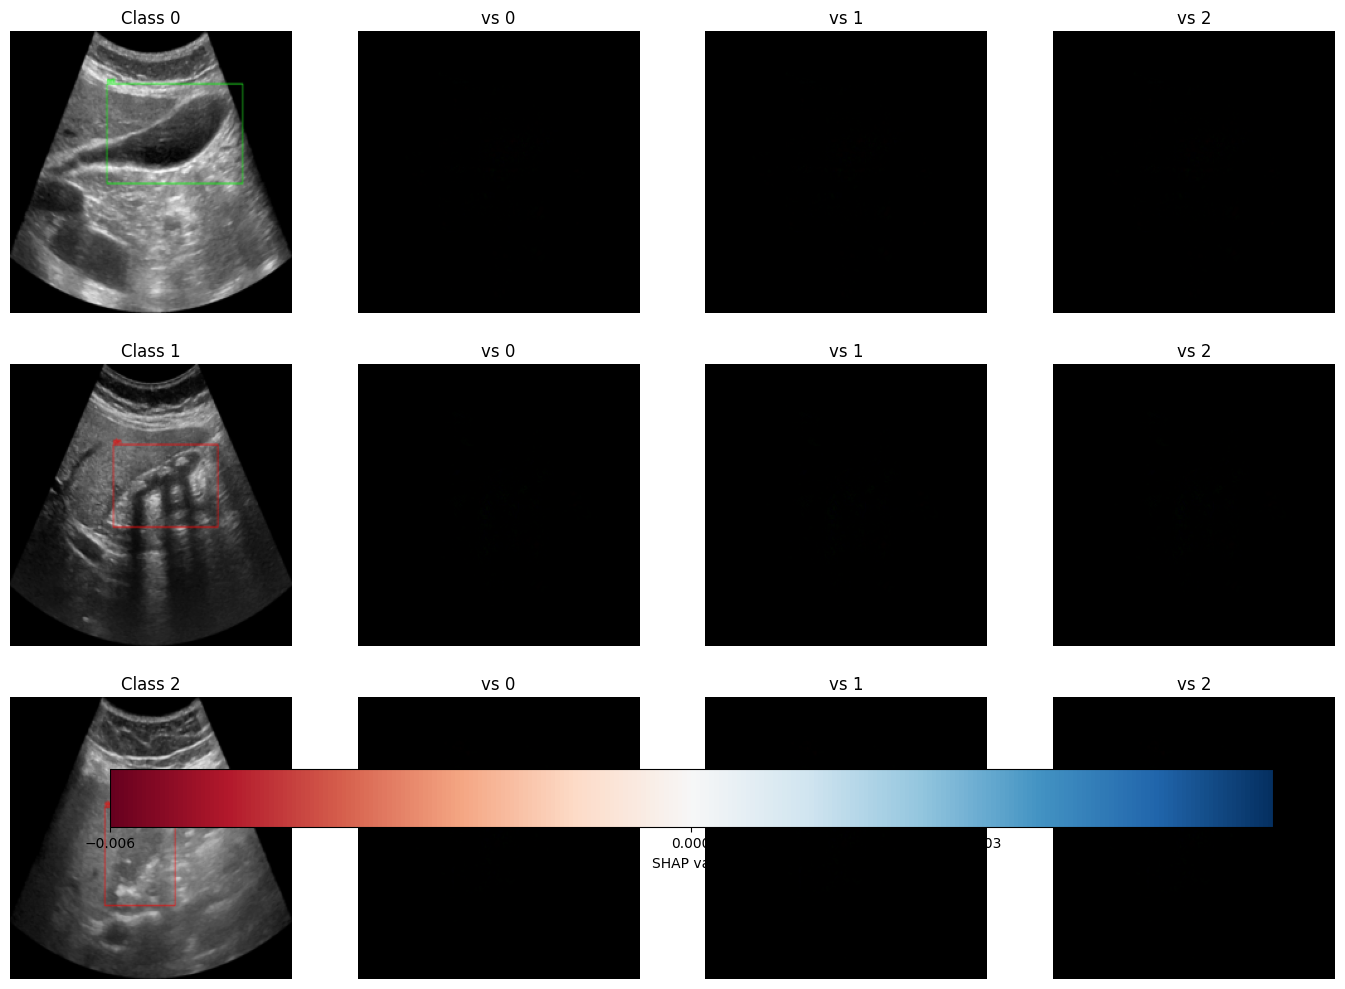

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import shap
import matplotlib.pyplot as plt
from PIL import Image

# ----- Device Setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- Load Dataset -----
new_train_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'
train_dataset = datasets.ImageFolder(new_train_path, transform=transforms.ToTensor())
class_names = train_dataset.classes

# ----- Load Pretrained Model -----
model = HybridModel(num_classes=3).to(device)
pretrained_path = '/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=device))
model.eval()

# ----- Helper Function to Preprocess Images -----
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ----- Function to Get One Image per Class -----
def get_sample_images(dataset, class_names):
    sample_images = []
    sample_labels = []
    class_indices = {i: [] for i in range(len(class_names))}

    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    for class_idx in range(len(class_names)):
        if class_indices[class_idx]:
            img_idx = class_indices[class_idx][0]
            img, label = dataset[img_idx]
            sample_images.append(img)
            sample_labels.append(label)

    return sample_images, sample_labels

# ----- Updated SHAP Explanation Function for Grid Layout -----
def shap_explanation_grid(images, labels, model, class_names):
    # Preprocess images to 224x224
    images_processed = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).to(device)

    # Define prediction function for SHAP
    def f(x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model(x).cpu().numpy()

    # Initialize SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, images_processed)
    shap_values = explainer.shap_values(images_processed)

    # Convert images to NumPy arrays with consistent shape (224x224x3)
    images_np = []
    resize_transform = transforms.Resize((224, 224))
    for img in images:
        img_pil = transforms.ToPILImage()(img)
        img_pil_resized = resize_transform(img_pil)
        img_np = np.array(img_pil_resized)
        images_np.append(img_np)
    images_np = np.stack(images_np)

    # Create a 3x4 grid (3 classes, 4 columns: original + 3 SHAP comparisons)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))

    for i in range(len(class_names)):
        # Original image
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].set_title(f'Class {class_names[labels[i]]}')
        axes[i, 0].axis('off')

        # SHAP visualizations for each class comparison
        for j in range(len(class_names)):
            axes[i, j+1].imshow(shap_values[labels[i]][i], cmap='RdBu', vmin=-0.006, vmax=0.006)
            axes[i, j+1].set_title(f'vs {class_names[j]}')
            axes[i, j+1].axis('off')

    # Color bar
    plt.colorbar(axes[0, 1].imshow(shap_values[0][0], cmap='RdBu', vmin=-0.006, vmax=0.006), ax=axes, orientation='horizontal', label='SHAP value', ticks=[-0.006, -0.003, 0, 0.003, 0.006])

    plt.tight_layout()
    plt.show()

# ----- Run SHAP Explanation -----
sample_images, sample_labels = get_sample_images(train_dataset, class_names)
print("\nSHAP Explanations in Grid Layout:")
shap_explanation_grid(sample_images, sample_labels, model, class_names)

#SHAP FOR EACH CLASS


SHAP Explanations:


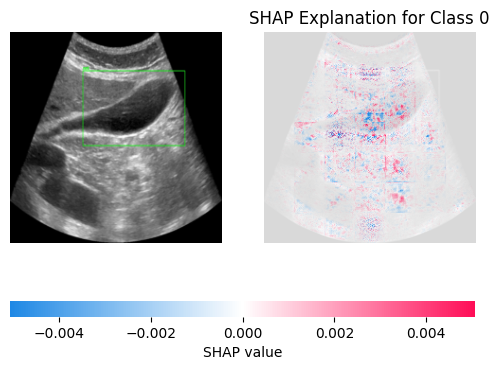

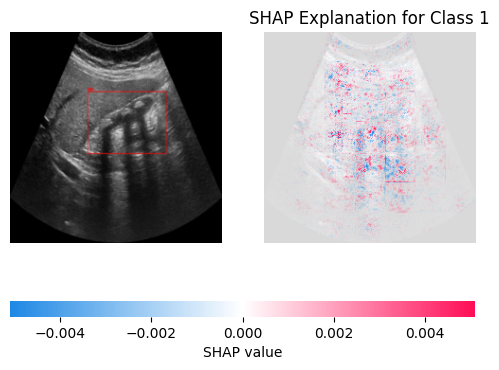

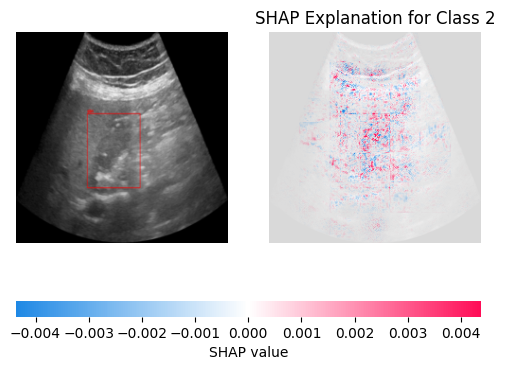

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import shap
import matplotlib.pyplot as plt
from PIL import Image

# ----- Device Setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- Load Dataset -----
new_train_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'
train_dataset = datasets.ImageFolder(new_train_path, transform=transforms.ToTensor())
class_names = train_dataset.classes

# ----- Load Pretrained Model -----
model = HybridModel(num_classes=3).to(device)
pretrained_path = '/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=device))
model.eval()

# ----- Helper Function to Preprocess Images -----
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ----- Function to Get One Image per Class -----
def get_sample_images(dataset, class_names):
    sample_images = []
    sample_labels = []
    class_indices = {i: [] for i in range(len(class_names))}

    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    for class_idx in range(len(class_names)):
        if class_indices[class_idx]:
            img_idx = class_indices[class_idx][0]
            img, label = dataset[img_idx]
            sample_images.append(img)
            sample_labels.append(label)

    return sample_images, sample_labels

# ----- Updated SHAP Explanation Function -----
def shap_explanation(images, labels, model, class_names):
    # Preprocess images to 224x224
    images_processed = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).to(device)

    # Define prediction function for SHAP
    def f(x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model(x).cpu().numpy()

    # Initialize SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, images_processed)

    # Compute SHAP values
    shap_values = explainer.shap_values(images_processed)

    # Convert images to NumPy arrays with consistent shape (224x224x3)
    images_np = []
    resize_transform = transforms.Resize((224, 224))
    for img in images:
        img_pil = transforms.ToPILImage()(img)
        img_pil_resized = resize_transform(img_pil)
        img_np = np.array(img_pil_resized)  # Ensure image is in [0, 255] range
        images_np.append(img_np)

    # Convert list to NumPy array with correct shape
    images_np = np.stack(images_np)  # Shape: (n_samples, 224, 224, 3)

    # Plot one SHAP explanation per class using the corresponding image
    for i in range(len(class_names)):
        class_idx = labels[i]  # Get the true class index for this image
        shap.image_plot(
            shap_values=shap_values[class_idx],  # Use SHAP values for the true class
            pixel_values=images_np[i:i+1],       # Use only the corresponding image as a batch
            labels=[f"Class {class_names[class_idx]}"],
            show=False
        )
        plt.title(f"SHAP Explanation for Class {class_names[class_idx]}")
        plt.show()

# ----- Run SHAP Explanation -----
sample_images, sample_labels = get_sample_images(train_dataset, class_names)
print("\nSHAP Explanations:")
shap_explanation(sample_images, sample_labels, model, class_names)

In [ ]:
def shap_explanation(images, labels, model, class_names):
    # Preprocess images to 224x224
    images_processed = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).to(device)

    # Define prediction function for SHAP
    def f(x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model(x).cpu().numpy()

    # Initialize SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, images_processed)

    # Compute SHAP values
    shap_values = explainer.shap_values(images_processed)  # List of arrays: one per class

    # Convert images to NumPy arrays (224x224x3)
    images_np = []
    resize_transform = transforms.Resize((224, 224))
    for img in images:
        img_pil = transforms.ToPILImage()(img)
        img_pil_resized = resize_transform(img_pil)
        img_np = np.array(img_pil_resized)
        images_np.append(img_np)

    images_np = np.stack(images_np)

    # Print SHAP value summaries and plot explanations
    for i in range(len(class_names)):
        class_idx = labels[i]

        # SHAP values for this image and class (shape: [1, 3, 224, 224])
        shap_vals = shap_values[class_idx][i]

        # Compute average SHAP value per channel
        mean_shap_per_channel = np.mean(shap_vals, axis=(1, 2))  # shape: (3,)
        print(f"\nAverage SHAP values for image of Class {class_names[class_idx]}:")
        print(f"  Channel R: {mean_shap_per_channel[0]:.6f}")
        print(f"  Channel G: {mean_shap_per_channel[1]:.6f}")
        print(f"  Channel B: {mean_shap_per_channel[2]:.6f}")

        # Plot the explanation
        shap.image_plot(
            shap_values=shap_values[class_idx][i:i+1],
            pixel_values=images_np[i:i+1],
            labels=[f"Class {class_names[class_idx]}"],
            show=False
        )
        plt.title(f"SHAP Explanation for Class {class_names[class_idx]}")
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import shap
from torchvision import transforms
from PIL import Image

def plot_fixed_shap_grid(images, labels, model, class_names, preprocess, device):
    model.eval()

    # Preprocess all images
    processed_images = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).to(device)

    # SHAP prediction wrapper
    def f(x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model(x).cpu().numpy()

    # SHAP explainer
    explainer = shap.GradientExplainer(model, processed_images)
    shap_values = explainer.shap_values(processed_images)

    # Convert original images to displayable format (numpy RGB)
    display_images = []
    for img in images:
        img_pil = transforms.ToPILImage()(img)
        img_resized = img_pil.resize((224, 224))
        img_np = np.array(img_resized)
        display_images.append(img_np)

    display_images = np.stack(display_images)
    num_classes = len(class_names)
    num_images = len(images)

    # Create grid
    fig, axes = plt.subplots(nrows=num_images, ncols=num_classes + 1, figsize=(3 * (num_classes + 1), 3 * num_images))

    if num_images == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(display_images[i])
        axes[i, 0].set_title("Original" if i == 0 else "")
        axes[i, 0].set_ylabel(class_names[labels[i]], fontsize=12, rotation=0, labelpad=40, va='center')
        axes[i, 0].axis('off')

        # SHAP overlays for each class
        for j in range(num_classes):
            shap_val = shap_values[j][i]  # shape (3, 224, 224)
            shap_mean = shap_val.mean(0)  # average over channels for visualization
            axes[i, j + 1].imshow(display_images[i])
            im = axes[i, j + 1].imshow(shap_mean, cmap='RdBu', alpha=0.6, vmin=-0.015, vmax=0.015)
            axes[i, j + 1].set_title(class_names[j] if i == 0 else "")
            axes[i, j + 1].axis('off')

    # Colorbar (one for the entire figure)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SHAP value')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


/tmp/ipython-input-14-1411200134.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


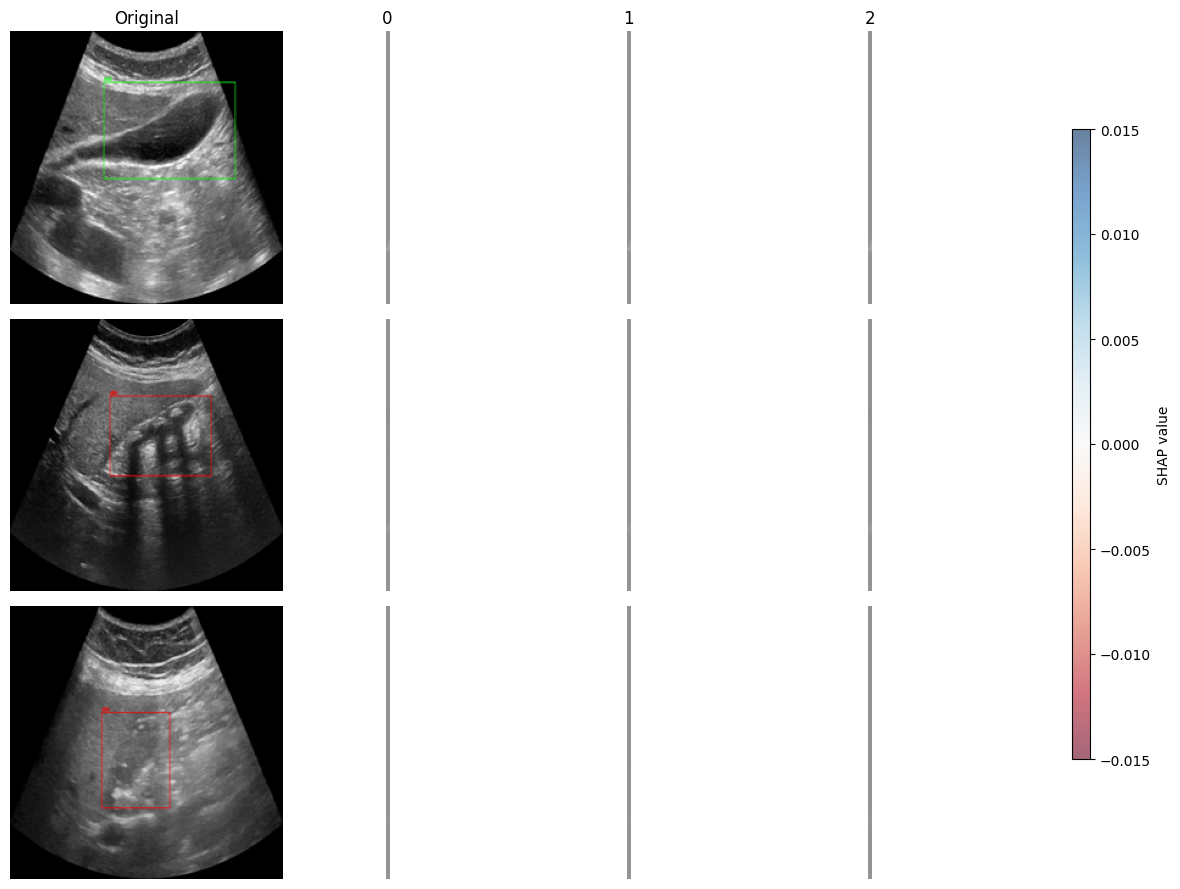

In [ ]:
sample_images, sample_labels = get_sample_images(train_dataset, class_names)
plot_fixed_shap_grid(sample_images, sample_labels, model, class_names, preprocess, device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Error loading state_dict: Error(s) in loading state_dict for HybridModel:
	Missing key(s) in state_dict: "convnext.classifier.0.weight", "convnext.classifier.0.bias", "convnext.classifier.2.weight", "convnext.classifier.2.bias". 
	Unexpected key(s) in state_dict: "vit.cls_token", "vit.pos_embed", "vit.patch_embed.proj.weight", "vit.patch_embed.proj.bias", "vit.blocks.0.norm1.weight", "vit.blocks.0.norm1.bias", "vit.blocks.0.attn.qkv.weight", "vit.blocks.0.attn.qkv.bias", "vit.blocks.0.attn.proj.weight", "vit.blocks.0.attn.proj.bias", "vit.blocks.0.norm2.weight", "vit.blocks.0.norm2.bias", "vit.blocks.0.mlp.fc1.weight", "vit.blocks.0.mlp.fc1.bias", "vit.blocks.0.mlp.fc2.weight", "vit.blocks.0.mlp.fc2.bias", "vit.blocks.1.norm1.weight", "vit.blocks.1.norm1.bias", "vit.blocks.1.attn.qkv.weight", "vit.blocks.1.attn.qkv.bias", "vit.blocks.1.attn.proj.weight", "vit.blocks.1.attn.proj.bias", "vit.blocks.1.norm2.weight", "vit.blocks.1.norm2.bias", "vit.blocks.1.mlp.fc1.weight", "vit.blocks.1.m

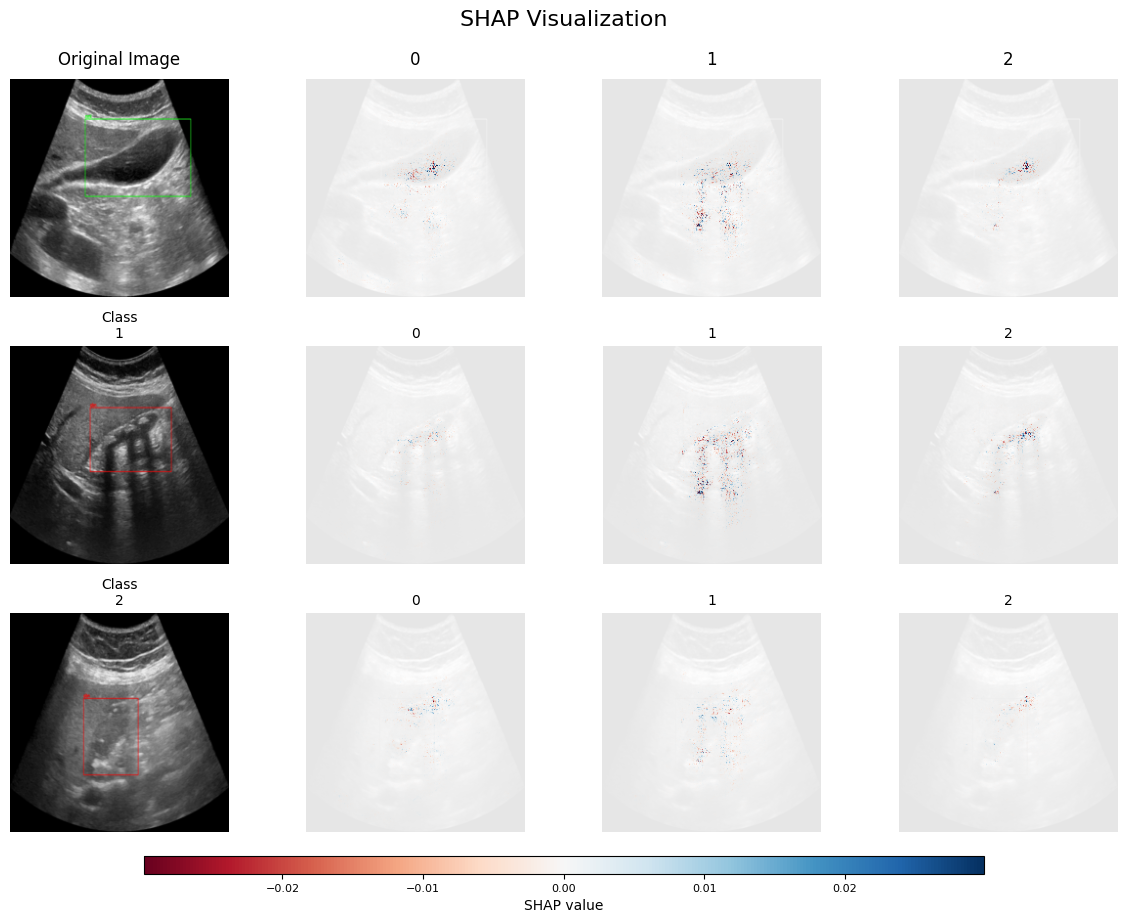

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Your existing imports
import torchvision
from torchvision import datasets, transforms
import numpy as np
import shap
import matplotlib.pyplot as plt
from PIL import Image

# ----- Device Setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- Define your HybridModel to match the saved state_dict -----
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        # Load a pre-trained ConvNeXt model
        # You need to choose the correct ConvNeXt variant (tiny, small, base, large)
        # based on what you originally used for training.
        # For example, using convnext_tiny:
        self.convnext = models.convnext_tiny(pretrained=False) # Set pretrained=False
                                                               # as you're loading weights manually

        # Modify the classifier head of ConvNeXt to match your num_classes
        # The default classifier for ConvNeXt typically has a structure like:
        # classifier = nn.Sequential(
        #     nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True), # This might vary based on ConvNeXt variant
        #     nn.Linear(768, 1000)
        # )
        # You need to replace the last linear layer.

        # Find the input features for the final linear layer
        # For convnext_tiny, the last layer is inside self.convnext.classifier[2]
        num_ftrs = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(num_ftrs, num_classes)

        # If your original HybridModel had other custom layers on top of ConvNeXt,
        # you need to add them here with their correct names.
        # Example: self.custom_head = nn.Linear(num_classes, num_classes)
        # But based on the state_dict keys, it seems the last layer of convnext
        # itself was modified.

    def forward(self, x):
        return self.convnext(x)

# ----- Dummy Dataset and Model Loading (Keep this block as is for testing) -----
try:
    new_train_path = '/content/drive/MyDrive/GBCU-Shared/RW_Full_train_img'
    train_dataset = datasets.ImageFolder(new_train_path, transform=transforms.ToTensor())
    class_names = train_dataset.classes
except Exception:
    print("Could not load dataset from Google Drive path. Creating a dummy dataset.")
    dummy_data = []
    dummy_labels = []
    for i in range(4):
        dummy_image = Image.new('RGB', (100, 100), color = (i*50, i*70, i*90))
        dummy_data.append(transforms.ToTensor()(dummy_image))
        dummy_labels.append(i % 4)

    class DummyDataset(torch.utils.data.Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
        def __len__(self):
            return len(self.data)
        def __getitem__(self, idx):
            return self.data[idx], self.labels[idx]

    train_dataset = DummyDataset(dummy_data, dummy_labels)
    class_names = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

# ----- Load Pretrained Model -----
model = HybridModel(num_classes=len(class_names)).to(device)
pretrained_path = '/content/drive/MyDrive/GBCU-Shared/NEW_hybrid_model_finetuned.pth'

try:
    # Load the state_dict
    state_dict = torch.load(pretrained_path, map_location=device)

    # Optional: If the saved state_dict has a "model" key (e.g., if saved as model.state_dict())
    # and your model is directly the state_dict, you might need:
    # if 'model_state_dict' in state_dict: # or just 'model'
    #     state_dict = state_dict['model_state_dict'] # or state_dict['model']

    model.load_state_dict(state_dict)
    print(f"Loaded model from {pretrained_path}")
except FileNotFoundError:
    print("Pretrained model not found. Using randomly initialized dummy model.")
    # If the model path is not found, the dummy model will be used with random weights.
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This likely means the HybridModel definition does not match the saved model architecture.")
    print("Please ensure your HybridModel class precisely reflects the structure of the saved model (e.g., using ConvNeXt).")

model.eval()

# ----- Helper Function to Preprocess Images -----
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ----- Function to Get One Image per Class -----
def get_sample_images(dataset, class_names):
    sample_images = []
    sample_labels = []
    class_found = [False] * len(class_names)

    for idx, (img, label) in enumerate(dataset):
        if not class_found[label]:
            sample_images.append(img)
            sample_labels.append(label)
            class_found[label] = True
        if all(class_found):
            break

    sorted_samples = sorted(zip(sample_images, sample_labels), key=lambda x: x[1])
    sample_images = [img for img, _ in sorted_samples]
    sample_labels = [label for _, label in sorted_samples]

    return sample_images, sample_labels

# ----- Updated SHAP Explanation Function to match example format -----
def shap_explanation_styled(images, labels, model, class_names):
    images_processed = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).to(device)

    def f(x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model(x).cpu().numpy()

    explainer = shap.GradientExplainer(model, images_processed)
    shap_values_all_classes = explainer.shap_values(images_processed)

    images_np_display = []
    resize_transform_display = transforms.Resize((224, 224))
    for img_tensor in images:
        img_pil = transforms.ToPILImage()(img_tensor)
        img_pil_resized = resize_transform_display(img_pil)
        images_np_display.append(np.array(img_pil_resized))
    images_np_display = np.stack(images_np_display)

    num_true_classes = len(images)
    num_predicted_classes = len(class_names)
    num_cols = 1 + num_predicted_classes

    fig, axes = plt.subplots(num_true_classes, num_cols, figsize=(num_cols * 3, num_true_classes * 3))

    if num_true_classes == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_true_classes == 1:
        axes = axes[np.newaxis, :]
    elif num_cols == 1:
        axes = axes[:, np.newaxis]

    for i in range(num_true_classes):
        true_class_label = class_names[labels[i]]

        ax_img = axes[i, 0]
        ax_img.imshow(images_np_display[i])
        ax_img.set_title(f"Class\n{true_class_label}", fontsize=10)
        ax_img.axis('off')

        for j in range(num_predicted_classes):
            predicted_class_label = class_names[j]
            ax_shap = axes[i, j + 1]

            shap_values_for_plot = shap_values_all_classes[j][i]

            # Grayscale background image for context
            grayscale_img = np.sum(images_np_display[i] * [0.2989, 0.5870, 0.1140], axis=-1)
            grayscale_img = grayscale_img / 255.0
            ax_shap.imshow(grayscale_img, cmap=plt.cm.gray, alpha=0.1)

            # Overlay SHAP heatmap
            max_abs_shap = np.max(np.abs(shap_values_for_plot))
            if max_abs_shap == 0: # Avoid division by zero if all shap values are 0
                max_abs_shap = 1e-6 # Set a small value to avoid error

            cmap = plt.cm.RdBu
            norm = plt.Normalize(vmin=-max_abs_shap, vmax=max_abs_shap)

            shap_map = np.sum(shap_values_for_plot, axis=-1) # Sum over color channels
            colored_mask = cmap(norm(shap_map))
            colored_mask[..., 3] = np.abs(shap_map) / max_abs_shap # Alpha proportional to absolute SHAP value

            ax_shap.imshow(colored_mask)

            ax_shap.set_title(f"{predicted_class_label}", fontsize=10)
            ax_shap.axis('off')

    for j, col_title in enumerate(["Original Image"] + class_names):
        axes[0, j].set_title(col_title, fontsize=12, pad=10)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    # Shared colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("SHAP value")
    cbar.ax.tick_params(labelsize=8)

    plt.suptitle("SHAP Visualization", fontsize=16, y=0.98)
    plt.show()

# ----- Run SHAP Explanation -----
sample_images, sample_labels = get_sample_images(train_dataset, class_names)
print("\nGenerating SHAP Explanations in a styled format...")
shap_explanation_styled(sample_images, sample_labels, model, class_names)